# CMSE381 Honors Project 
#### <p style="text-align: left;"> *Anshul Srivastava* </p>                                                                            

## Introduction

In today's digital age, the demand for robust and efficient facial recognition systems has surged across various domains, including security, authentication, surveillance, and human-computer interaction. The ability to accurately identify and verify individuals from images or video streams holds immense potential for enhancing security protocols, streamlining authentication processes, and improving user experiences in various applications.

The goal of this project is to develop a facial recognition system using Support Vector Machines (SVM), a powerful machine learning algorithm known for its effectiveness in classification tasks. We leverage the Labeled Faces in the Wild (LFW) dataset, a widely used benchmark dataset in the field of face recognition, containing a diverse set of facial images collected from the web.

Our approach involves several key steps, including data preprocessing, feature extraction using Principal Component Analysis (PCA) for dimensionality reduction, model building using SVM with hyperparameter tuning, and comprehensive evaluation of the model's performance.

Through this project, we aim to demonstrate the efficacy of SVM-based facial recognition systems and explore the impact of various factors, such as hyperparameters and feature representation, on the system's performance. Additionally, we seek to gain insights into the challenges and opportunities associated with building and deploying facial recognition systems in real-world scenarios.

In the following sections, we provide a detailed overview of the dataset, our methodology, experimental setup, results, and discussion, followed by conclusions and avenues for future research.

## Standard Imports

These are the libraries we have been working with throughout the semester. 

In [77]:
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_lfw_people

## Dataset

The Labeled Faces in the Wild (LFW) dataset, accessible through the scikit-learn library, is a widely used benchmark dataset for face recognition tasks. It consists of a collection of facial images extracted from various online sources, such as news articles, Google Images, and celebrity websites. The dataset contains images of faces belonging to different individuals, captured under a variety of conditions, including varying lighting, pose, and facial expressions. 

With over 13,000 images of approximately 5,000 individuals, LFW offers a diverse and challenging dataset for evaluating the performance of facial recognition algorithms. Each image in the dataset is labeled with the corresponding identity of the individual depicted, providing ground truth for training and evaluation purposes. This rich and expansive dataset serves as a valuable resource for researchers and practitioners working in the field of computer vision and machine learning, facilitating advancements in facial recognition technology.

For the purpose of this project, I only import those persons who have atleast 50 unique images. This ensures our model has enough data to train on to classify a particular individual. This is ensured by the *min_faces_per_person* argument. Furthermore, the images are resized to 40% of their original size to maximize efficiency and speed.

In [78]:
#import the data through sklearn
sk_data = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

#extract features, labels, and names from the data
feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names

n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

The following cell helps us understand the dataset in greater depth. We see the distribution of images for different people. The code prints the number of unique images associated with each person.

In [12]:
images_per_person = {}

# Count the number of images for each person
for label in class_labels:
    if label in images_per_person:
        images_per_person[label] += 1
    else:
        images_per_person[label] = 1

# Print the count of images for each person
for person_id, count in images_per_person.items():
    person_name = categories[person_id]
    print(f"{person_name} has {count} images.")

Tony Blair has 144 images.
Gerhard Schroeder has 109 images.
Donald Rumsfeld has 121 images.
George W Bush has 530 images.
Colin Powell has 236 images.
Ariel Sharon has 77 images.
Serena Williams has 52 images.
John Ashcroft has 53 images.
Hugo Chavez has 71 images.
Jean Chretien has 55 images.
Junichiro Koizumi has 60 images.
Jacques Chirac has 52 images.


Now, we aim to visualize our dataset. The following code prints out one image for each person in the dataset, in grayscale. As we can see, we have 12 unique individuals in this dataset.

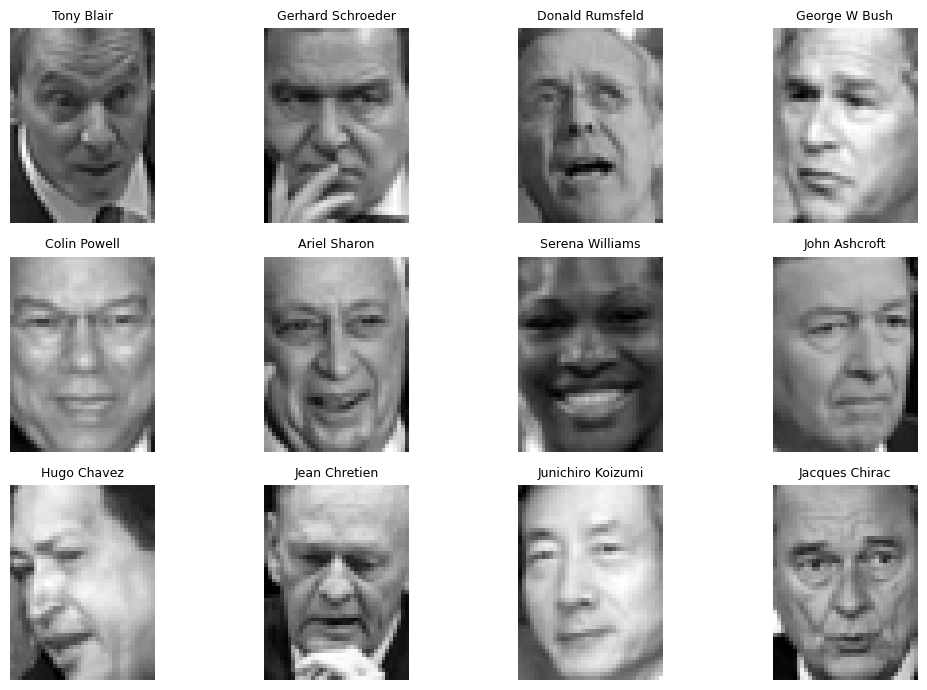

In [70]:
images = sk_data.images
fig, axes = plt.subplots(3, 4, figsize=(11, 7))
axes = axes.ravel()

for i, (person_id, count) in enumerate(images_per_person.items()):
    idx = (class_labels == person_id).argmax()
    # Plot the image
    axes[i].imshow(images[idx], cmap='gray')
    axes[i].set_title(categories[person_id], size=9)
    axes[i].axis('off')

plt.tight_layout()
#plt.savefig('Images.png', dpi=400, format='png')

## Preprocessing - PCA and Train-Test Split

We apply the Principal Component Analysis (PCA) algorithm as a crucial preprocessing step to reduce the dimensionality of the feature space. PCA enables us to transform the high-dimensional feature vectors extracted from facial images into a lower-dimensional representation while preserving as much of the original variance as possible. By retaining the most informative components and discarding less relevant ones, PCA simplifies the computational complexity of subsequent processing steps and mitigates the curse of dimensionality. 

This reduction in dimensionality not only expedites the training process but also helps in combating overfitting, thereby enhancing the generalization capability of the model. Furthermore, PCA aids in uncovering the underlying structure and patterns present in the data, facilitating better interpretation and understanding of the feature space. Overall, the application of PCA in this project is essential for optimizing the efficiency and effectiveness of the facial recognition system, ultimately improving its performance and usability in real-world applications.

We can see this process takes the original feature matrix of the shape (1560, 1850), and transforms into a new PCA matrix of shape (1560, 172). We then apply a standard train-test split to this transformed matrix.

In [15]:
print('Feature matrix shape is: ', feature_vectors.shape)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_vectors)

# Perform PCA
pca = PCA()
pca.fit(scaled_features)

# Determine the number of components explaining 95% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.95) + 1

# Transform the features using the optimal number of components
pca = PCA(n_components=num_components)
pca_features = pca.fit_transform(scaled_features)

print("Number of PCA components explaining 95% variance:", num_components)
print("PCA features shape:", pca_features.shape)

Feature matrix shape is:  (1560, 1850)
Number of PCA components explaining 95% variance: 172
PCA features shape: (1560, 172)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(pca_features, class_labels, test_size=0.25, random_state=42)

## Building an SVM Model

We employ a Support Vector Machine (SVM) algorithm for facial recognition, leveraging its robust classification capabilities. The SVM algorithm is particularly well-suited for binary and multiclass classification tasks, making it an ideal choice for our facial recognition system. By maximizing the margin between different classes in the feature space, SVM aims to find an optimal hyperplane that separates the data points belonging to different individuals.

Through extensive hyperparameter tuning using techniques such as GridSearchCV, we identify the most suitable parameters for our SVM model, including the regularization parameter (C) and the kernel coefficient (gamma). This meticulous parameter optimization process ensures that our SVM model generalizes well to unseen data and achieves high accuracy in classifying facial images. By harnessing the power of SVM, we aim to build a robust and reliable facial recognition system capable of accurately identifying individuals across diverse conditions and scenarios.

In [58]:
# Train a SVM classification model
start = time.time()

print("Fitting the classifier to the training set")
# a dictionary of hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear']}
# make a classifier by searching over a classifier and the parameter grid
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=10)

# we have a "good" classifier (according to GridSearchCV)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)

end = time.time()
print("Runtime",end - start)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=0.01, class_weight='balanced', gamma=0.0001, kernel='linear')
Best parameters found by grid search:
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
Runtime 65.26925897598267


## Testing the Model

Following the training of our Support Vector Machine (SVM) classification model, we proceed to make predictions on the test set to assess its performance and accuracy. Leveraging the best estimator obtained through GridSearchCV, we apply the trained SVM model to the unseen test data. By predicting the identities of individuals depicted in the test images, we evaluate the model's ability to generalize to new and unseen data. Subsequently, we calculate the accuracy of the model by comparing its predictions to the ground truth labels. Additionally, we generate a detailed classification report, which provides insights into the precision, recall, and F1-score for each class in the dataset. This comprehensive evaluation allows us to assess the model's performance across different classes and identify any potential areas for improvement. Moreover, we visualize the results using a confusion matrix, which provides a clear depiction of the model's performance in classifying different individuals. By analyzing these metrics and visualizations, we gain a deeper understanding of the SVM model's effectiveness in facial recognition tasks and its overall accuracy in identifying individuals from facial images.

Predicting names on the test set
Accuracy: 80.3%
                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.81      0.72        16
     Colin Powell       0.79      0.89      0.84        66
  Donald Rumsfeld       0.62      0.74      0.68        27
    George W Bush       0.92      0.80      0.85       140
Gerhard Schroeder       0.66      0.79      0.72        24
      Hugo Chavez       1.00      0.71      0.83        17
   Jacques Chirac       0.70      0.70      0.70        10
    Jean Chretien       0.69      0.79      0.73        14
    John Ashcroft       0.72      0.81      0.76        16
Junichiro Koizumi       0.89      0.73      0.80        11
  Serena Williams       0.89      0.89      0.89         9
       Tony Blair       0.82      0.78      0.79        40

         accuracy                           0.80       390
        macro avg       0.78      0.79      0.78       390
     weighted avg       0.82      0.80      0.81       390



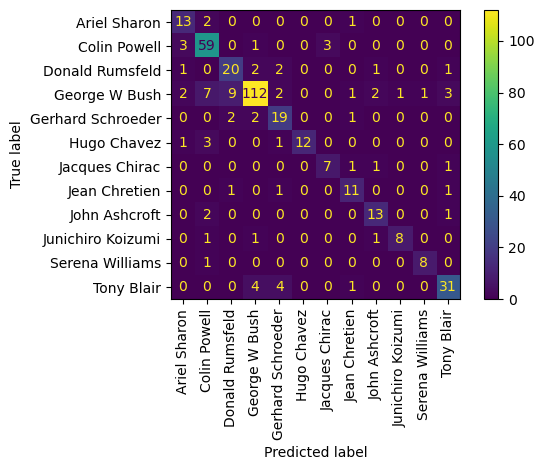

In [71]:
print("Predicting names on the test set")
clf_best = clf.best_estimator_
pred = clf_best.predict(X_test)

print(f"Accuracy: {clf_best.score(X_test, y_test)*100:.1f}%")
print(classification_report(y_test, pred, target_names=categories))

ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=categories, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Visualizing the Predictions

The provided function `plot_gallery` serves as a visualization tool to plot a gallery of sample images from the test set along with their corresponding predicted and actual labels. The function takes as input the test images (`images`), the true labels (`true_titles`), the predicted labels (`pred_titles`), as well as the height (`h`) and width (`w`) dimensions of the images. Additionally, the function allows customization of the layout with parameters `n_row` and `n_col`, which specify the number of rows and columns in the grid of subplots.

Within the function, each image is reshaped to its original dimensions using the Principal Component Analysis (PCA) components, allowing for visualization in its original format. The images are then plotted as grayscale portraits, with the predicted label displayed as the subplot title and the actual label as the xlabel. By utilizing Matplotlib's subplot functionality, the function generates a grid of subplots containing the sample images, enabling easy comparison between the predicted and actual labels.

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_895/2184052881.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


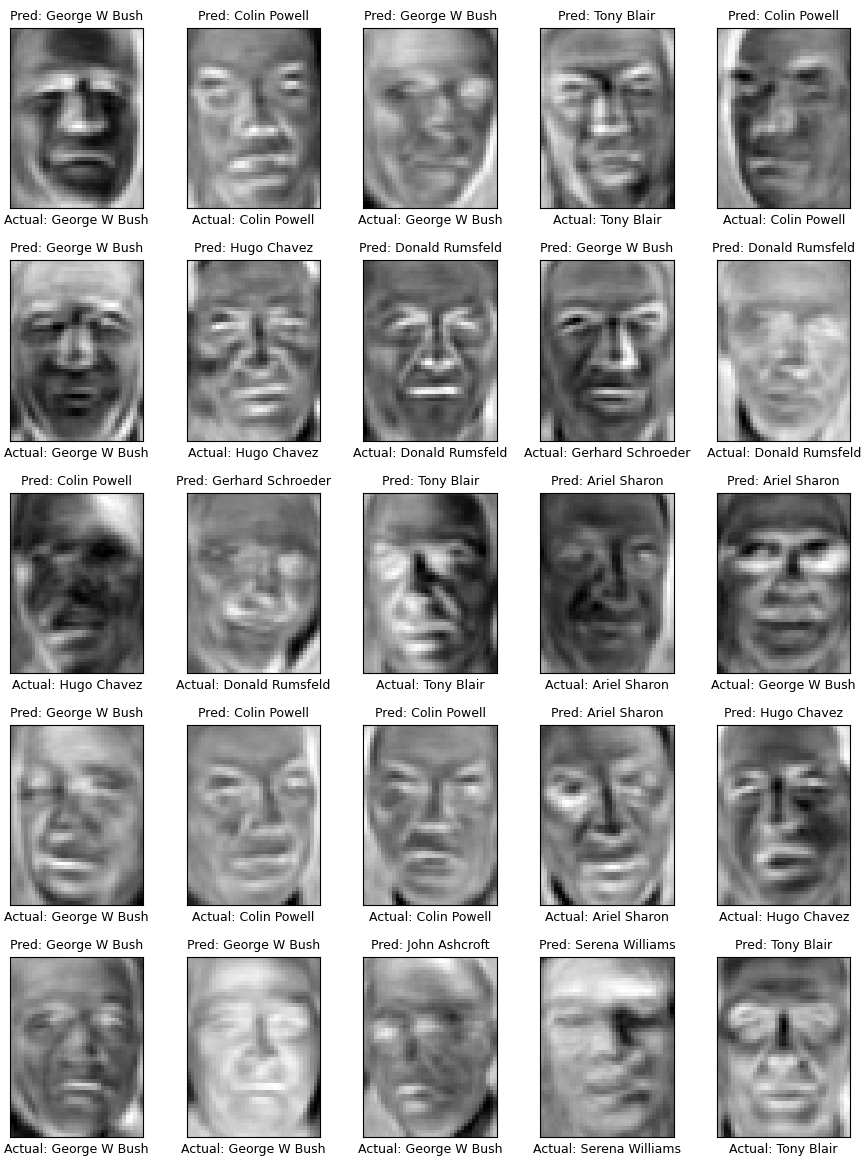

In [74]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        img = np.dot(images[i], pca.components_).reshape((h, w))
        plt.imshow(img, cmap=plt.cm.gray_r)
        plt.title('Pred: '+str(categories[pred_titles[i]]), size=9)
        plt.xlabel('Actual: '+str(categories[true_titles[i]]), size=9)
        plt.tight_layout()
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_test, y_test, pred, h,w)
plt.savefig('Preds.png', dpi=400, format='png')

## Model Analytics

Next, we conduct a learning curve analysis for the SVM model trained on the facial recognition dataset. The learning curve illustrates the performance of the model as a function of the number of training examples used. The `learning_curve` function from scikit-learn computes the training and cross-validation scores across different training set sizes, allowing for the visualization of the model's learning behavior. The mean and standard deviation of the training and cross-validation scores are calculated to provide insights into the model's performance variability. The resulting learning curve is plotted using Matplotlib, with the number of training examples on the x-axis and the model score (accuracy) on the y-axis. Additionally, shaded areas around the curves represent the standard deviation of the scores, providing an indication of the variability in performance. By analyzing the learning curve, we can assess the model's ability to generalize to unseen data as the training set size increases and identify any trends or patterns in its learning behavior.

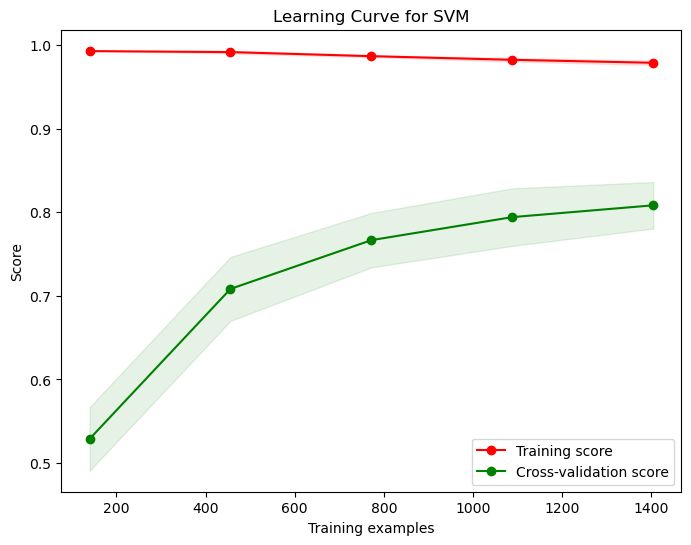

In [75]:
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    clf.best_estimator_, pca_features, class_labels, cv=10, scoring='accuracy')

# Compute mean and standard deviation of training scores and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve for SVM")
plt.legend(loc="best")
plt.savefig('LC.png', dpi=400, format='png')

Finally, we conduct a validation curve analysis for the SVM model to explore the impact of varying hyperparameters on model performance. The analysis focuses on two hyperparameters: the regularization parameter C and the kernel coefficient gamma.

For the regularization parameter C, a range of values is specified, and the validation_curve function computes the training and cross-validation scores for each value of C. The mean and standard deviation of these scores are then calculated to provide insights into the model's performance variability. The resulting validation curve is plotted using Matplotlib, with C values on the x-axis and the model score (accuracy) on the y-axis. Shaded areas around the curves represent the standard deviation of the scores, indicating the variability in performance.

Similarly, the process is repeated for the kernel coefficient gamma, with a range of gamma values specified and the corresponding validation curve plotted. The generated validation curves allow us to visualize how changes in hyperparameter values affect the model's performance and identify optimal hyperparameter settings that maximize model accuracy.

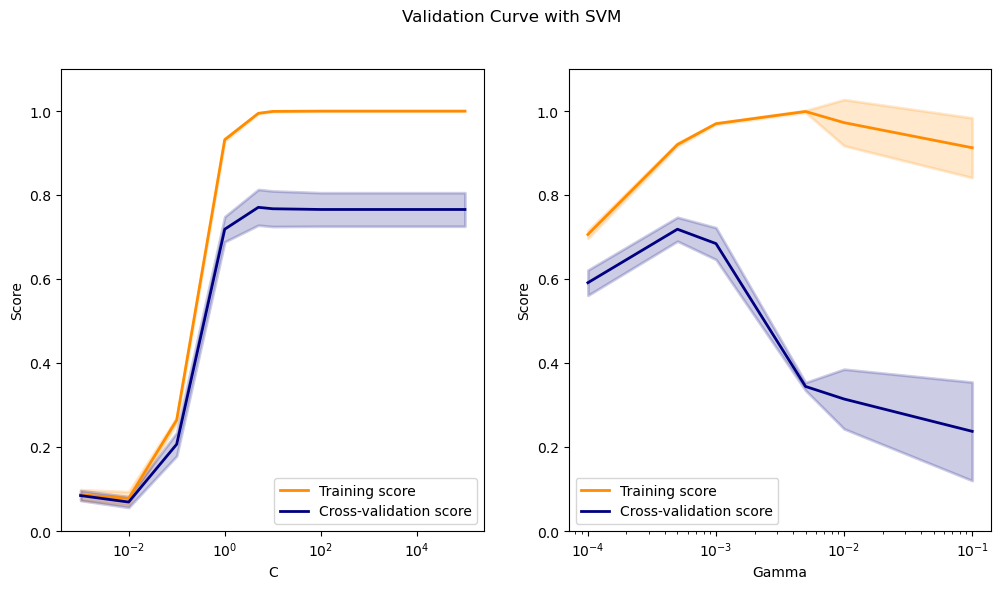

In [76]:
from sklearn.model_selection import validation_curve

# Define the hyperparameter values to test
param_range = [0.001, 0.01, 0.1, 1, 5, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5]

# Compute training and validation scores for varying parameter values
train_scores, test_scores = validation_curve(
    SVC(class_weight='balanced'), X_train, y_train, param_name="C", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(12, 6))
plt.suptitle("Validation Curve with SVM")
plt.subplot(121)
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=2)
plt.legend(loc="best")

param_range_gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]

# Compute training and validation scores for varying gamma values
train_scores_gamma, test_scores_gamma = validation_curve(
    SVC(class_weight='balanced'), X_train, y_train, param_name="gamma", param_range=param_range_gamma,
    cv=10, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation of training and test scores
train_scores_mean_gamma = np.mean(train_scores_gamma, axis=1)
train_scores_std_gamma = np.std(train_scores_gamma, axis=1)
test_scores_mean_gamma = np.mean(test_scores_gamma, axis=1)
test_scores_std_gamma = np.std(test_scores_gamma, axis=1)

# Plot validation curve for gamma
plt.subplot(122)
plt.xlabel("Gamma")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range_gamma, train_scores_mean_gamma, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range_gamma, train_scores_mean_gamma - train_scores_std_gamma, train_scores_mean_gamma + train_scores_std_gamma, alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range_gamma, test_scores_mean_gamma, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range_gamma, test_scores_mean_gamma - test_scores_std_gamma, test_scores_mean_gamma + test_scores_std_gamma, alpha=0.2, color="navy", lw=2)
plt.legend(loc="best")
plt.savefig('VC.png', dpi=400, format='png')

## Conclusion

In this project, we developed a facial recognition system utilizing Support Vector Machines (SVM) on the Labeled Faces in the Wild (LFW) dataset. Through meticulous preprocessing, including dimensionality reduction with Principal Component Analysis (PCA), we transformed high-dimensional facial images into informative feature vectors. The SVM model, trained and optimized using techniques such as GridSearchCV for hyperparameter tuning, demonstrated strong performance in accurately identifying individuals from facial images.

Our analysis revealed the effectiveness of SVM in facial recognition tasks, achieving significant accuracy in classifying faces across diverse conditions and expressions. The learning curve and validation curve analyses provided valuable insights into the model's learning behavior and the impact of hyperparameters on its performance.

Furthermore, the comprehensive evaluation of the model's predictions on the test set, including the calculation of accuracy, precision, recall, and F1-score, demonstrated the robustness and generalization capability of the SVM model.

Overall, this project contributes to the field of facial recognition by showcasing the effectiveness of SVM algorithms and providing a framework for building accurate and reliable facial recognition systems. Future research directions may include exploring advanced deep learning techniques for facial feature extraction and further refining the model's performance on challenging datasets. By advancing the state-of-the-art in facial recognition technology, we aim to enable applications in security, authentication, and human-computer interaction, contributing to a safer and more efficient digital environment.